# Amazon Fine Food Reviews 

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 <br>
Number of users: 256,059 <br>
Number of products: 74,258 <br>
Timespan: Oct 1999 - Oct 2012 <br>
Number of Attributes/Columns in data: 10 <br> 

**Attribute Information:**
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful (YES)
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not (YES+NO)
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

In [101]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import re

We are using the sqlite database to fetch the recrods. Since the dataset is huge, it is difficult to operate the CSV file. So,by using the sqlite database, the queries can be applied on the dataset and the results will be faster.

In [102]:
db_path='database.sqlite'
conn=sqlite3.connect(db_path)

data=pd.read_sql_query('SELECT * FROM Reviews LIMIT 10000',conn)


Dividing each star rating and trying to visualize the distribution of ratings over the items in dataset

In [103]:
def star_rating(l,i):
    rating_list=[]
    for x in l:
        if(x==i):
           rating_list.append(i)
    return rating_list

In [104]:
rating=data['Score']

one_star=star_rating(rating,1)
two_star=star_rating(rating,2)
three_star=star_rating(rating,3)
four_star=star_rating(rating,4)
five_star=star_rating(rating,5)

Plotting the bar graph of distribution of food items in the dataset 

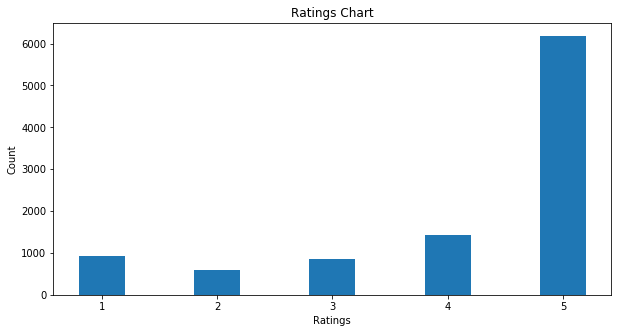

In [105]:
d={1:len(one_star),2:len(two_star),3:len(three_star),4:len(four_star),5:len(five_star)}

x=list(d.keys())
y=list(d.values())

fig=plt.figure(figsize=(10, 5))
plt.bar(x,y,width=0.4)

plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Ratings Chart')
plt.show()

Filtering the users from the dataset who have given atleast one rating. Because, the users who didn't give any rating will not be useful.

In [106]:
data1=pd.read_sql_query('SELECT UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1 LIMIT 10000',conn)
print(data1.shape)

(10000, 9)


In [107]:
distinct_product_id=pd.read_sql_query('SELECT DISTINCT ProductId FROM Reviews LIMIT 10000',conn)
print(len(distinct_product_id))

10000


If you clearly observe the result of below query, the same person LINDA Riley has given multiple reviews for different products in the same timestamp. How is it possible? Because it takes some time to write a review. <br>
If you goto the website and check these products, the products are similar but they are of different flavours. There is no rule that if one flavour is good, the other flavours of same product also have to be good.

In [108]:
duplicate_reviews=pd.read_sql_query('SELECT * FROM Reviews GROUP BY UserId,ProductId HAVING COUNT(*)>1 LIMIT 10000',conn)
print(len(duplicate_reviews))
duplicate_reviews.head()

5859


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,239325,B00008DFK5,A102TGNH1D915Z,LINDA Riley,2,3,4,1262131200,Not just for puppies...,"Although the product can be a bit pricey, it c..."
1,258132,B0002DHNXC,A102TGNH1D915Z,LINDA Riley,2,3,4,1262131200,Not just for puppies...,"Although the product can be a bit pricey, it c..."
2,58616,B0009YD7P2,A102TGNH1D915Z,LINDA Riley,2,3,4,1262131200,Not just for puppies...,"Although the product can be a bit pricey, it c..."
3,27840,B000SP1CWW,A102TGNH1D915Z,LINDA Riley,2,3,4,1262131200,Not just for puppies...,"Although the product can be a bit pricey, it c..."
4,389731,B0008IT4OM,A106N4B4EG4DR8,"Monday ""Pamela""",0,0,5,1210118400,Full praise for these delicious morsals that m...,Yummy is all you need to know. Simply deliciou...


Sorting the reviews according to the ProductId

In [109]:
data2=data1.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
print(data2.shape)
data2.head()

(10000, 9)


,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*)
9952,A1GQUBNRZK3RHI,B00002N8SM,X. Li,0,0,1279411200,1,This product does not work at all. I hang it i...,2
5561,A196AJHU9EASJN,B00002NCJC,Alex Chaffee,0,0,1282953600,4,Why is this $[...] when the same product is av...,2
2319,A13RRPGE79XFFH,B00002NCJC,reader48,0,0,1281052800,5,We have used the Victor fly bait for 3 seasons...,2
3414,A15N6S5GN8NHM7,B00004RAMY,L. Paul Joseph,0,0,1341878400,5,I'm looking forward to using this trap on a il...,2
9588,A1G65L9BLQ4R9W,B00004RBDW,tbrochny,0,1,1279152000,5,I've just installed the third unit in our gara...,3


In [110]:
data3=data2.drop_duplicates(subset={"UserId","ProductId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Time","Score","Text"}, keep='first', inplace=False)
print(data3.shape)

(10000, 9)


HelpfulnessNumerator = total no. of users that found review is helpful  <br>
HelpfulnessDenominator = sum of total no. of users that found review is both helpful and not helpful  <br>

The value of HelpfulnessDenominator should be greater than or equal to the value of HelpfulnessNumerator. <br>

In [111]:
helpfullness=pd.read_sql_query('SELECT * FROM Reviews WHERE HelpfulnessNumerator>HelpfulnessDenominator LIMIT 10000',conn)
helpfullness.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Eliminating the reviews which are violating the above property

In [112]:
data4=data3[data3['HelpfulnessNumerator']<=data3['HelpfulnessDenominator']]
data4.head()

,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*)
9952,A1GQUBNRZK3RHI,B00002N8SM,X. Li,0,0,1279411200,1,This product does not work at all. I hang it i...,2
5561,A196AJHU9EASJN,B00002NCJC,Alex Chaffee,0,0,1282953600,4,Why is this $[...] when the same product is av...,2
2319,A13RRPGE79XFFH,B00002NCJC,reader48,0,0,1281052800,5,We have used the Victor fly bait for 3 seasons...,2
3414,A15N6S5GN8NHM7,B00004RAMY,L. Paul Joseph,0,0,1341878400,5,I'm looking forward to using this trap on a il...,2
9588,A1G65L9BLQ4R9W,B00004RBDW,tbrochny,0,1,1279152000,5,I've just installed the third unit in our gara...,3


# Text preprocessing

In [113]:
r1=data4['Text'].values[0]
print(r1)
print('-'*100)

r2=data4['Text'].values[100]
print(r2)
print('-'*100)

r3=data4['Text'].values[500]
print(r3)
print('-'*100)

r4=data4['Text'].values[200]
print(r4)

This product does not work at all. I hang it in the kitchen for 5 days but no fly has been attracted!<br /><br />It doesn't worth the time and money to return it. But please, buyer beware, I strongly suggest you go find some other item.
----------------------------------------------------------------------------------------------------
I have tried allot of bacon over the years and this is the best one I have found. Very heavy smoke, but does not taste bitter or acrid. Smells smokier than it tastes, it will perfume your kitchen. This is also very lean bacon so don't worry that you are paying for some very expensive fat. Still, it's not cheap and you have to be a hard core bacon lover to pay that much, especially if you have to pay shipping on top of it. Would be a great gift though.
----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet, as I find that I can no longer tolerate even natural sugars like

1. We need to eliminate all the html tags from the reviews and remove the stop words to apply Bag of Words technique. <br>
2. convert all the reviews into lowercase for simplicity. <br>
3. Some users have put the links to other websites. So, we also have to remove the links from reviews. <br>
4. Remove all the special characters like &,@,$,# from the reviews. <br>
5. Remove the alphanumeric words  
6. Remove all the stop words. Stop words have no use in pre-processing. They are used just for the grammatical meaning of the sentence. <br>
7. Apply stemming

In [114]:
#removing the HTML tags from the reviews

CLEANR=re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

k=0
for review in data4['Text']:
    r=re.sub(CLEANR,' ',review)
    data4['Text'].values[k]=r
    k+=1
    

Reviews after removing the HTML tags

In [121]:
print(data4['Text'].values[0])
print('-'*100)

print(data4['Text'].values[500])

This product does not work at all I hang it in the kitchen for   days but no fly has been attracted It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item 
----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and dates These raise the blood sugar which spikes the insulin a hormone whose message is store fat Insulin also causes the kidneys to retain water and therefore I would bloat from a high carb diet My dilemma is that I love sweets and now it is not a problem thanks to products like stevia a natural plant that has safely been used in parts of the world as a sweetener for hundreds of years It has no calories and no impact on the blood sugar although for some people there might be a bit as the brain is tricked into thinking it is getting sugar Stevia used to

In [115]:
#removing the special characters

r1=re.sub(r'[^A-Za-z0-9]+',' ',r1,flags=re.MULTILINE)
r2=re.sub(r'[^A-Za-z0-9]+',' ',r2,flags=re.MULTILINE)
r3=re.sub(r'[^A-Za-z0-9]+',' ',r3,flags=re.MULTILINE)
r4=re.sub(r'[^A-Za-z0-9]+',' ',r4,flags=re.MULTILINE)

print(r1,'\n','-'*100)
print(r2,'\n','-'*100)
print(r3,'\n','-'*100)
print(r4,'\n','-'*100)

k=0
for review in data4['Text']:
    review=re.sub(r'[^A-Za-z0-9]+',' ',review)
    #print(review)
    data4['Text'].values[k]=review;
    k+=1


This product does not work at all I hang it in the kitchen for 5 days but no fly has been attracted br br It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item  
 ----------------------------------------------------------------------------------------------------
I have tried allot of bacon over the years and this is the best one I have found Very heavy smoke but does not taste bitter or acrid Smells smokier than it tastes it will perfume your kitchen This is also very lean bacon so don t worry that you are paying for some very expensive fat Still it s not cheap and you have to be a hard core bacon lover to pay that much especially if you have to pay shipping on top of it Would be a great gift though  
 ----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and

Reviews after removing the special characters

In [116]:
print(data4['Text'].values[0])
print('-'*100)

print(data4['Text'].values[500])

This product does not work at all I hang it in the kitchen for 5 days but no fly has been attracted It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item 
----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and dates These raise the blood sugar which spikes the insulin a hormone whose message is store fat Insulin also causes the kidneys to retain water and therefore I would bloat from a high carb diet My dilemma is that I love sweets and now it is not a problem thanks to products like stevia a natural plant that has safely been used in parts of the world as a sweetener for hundreds of years It has no calories and no impact on the blood sugar although for some people there might be a bit as the brain is tricked into thinking it is getting sugar Stevia used to

In [117]:
#removing alphanumeric words 

r1=re.sub(r'\w*\d\w*',' ',r1,flags=re.MULTILINE)
r2=re.sub(r'\w*\d\w*',' ',r2,flags=re.MULTILINE)
r3=re.sub(r'\w*\d\w*',' ',r3,flags=re.MULTILINE)
r4=re.sub(r'\w*\d\w*',' ',r4,flags=re.MULTILINE)

print(r1,'\n','-'*100)
print(r2,'\n','-'*100)
print(r3,'\n','-'*100)
print(r4,'\n','-'*100)

# applying the above technique on all the reviews
k=0
for review in data4['Text']:
    review=re.sub(r'\w*\d\w*',' ',review)
    #print(review)
    data4['Text'].values[k]=review;
    k+=1
    

This product does not work at all I hang it in the kitchen for   days but no fly has been attracted br br It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item  
 ----------------------------------------------------------------------------------------------------
I have tried allot of bacon over the years and this is the best one I have found Very heavy smoke but does not taste bitter or acrid Smells smokier than it tastes it will perfume your kitchen This is also very lean bacon so don t worry that you are paying for some very expensive fat Still it s not cheap and you have to be a hard core bacon lover to pay that much especially if you have to pay shipping on top of it Would be a great gift though  
 ----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and

Reviews after removing the alphanumeric words

In [118]:
print(data4['Text'].values[0])
print('-'*100)

print(data4['Text'].values[500])

This product does not work at all I hang it in the kitchen for   days but no fly has been attracted It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item 
----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and dates These raise the blood sugar which spikes the insulin a hormone whose message is store fat Insulin also causes the kidneys to retain water and therefore I would bloat from a high carb diet My dilemma is that I love sweets and now it is not a problem thanks to products like stevia a natural plant that has safely been used in parts of the world as a sweetener for hundreds of years It has no calories and no impact on the blood sugar although for some people there might be a bit as the brain is tricked into thinking it is getting sugar Stevia used to

In [119]:
#removing the links from the reviews 

r1=re.sub(r'^https?:\/\/.*[\r\n]*',' ',r1,flags=re.MULTILINE)
r2=re.sub(r'^https?:\/\/.*[\r\n]*',' ',r2,flags=re.MULTILINE)
r3=re.sub(r'^https?:\/\/.*[\r\n]*',' ',r3,flags=re.MULTILINE)
r4=re.sub(r'^https?:\/\/.*[\r\n]*',' ',r4,flags=re.MULTILINE)

print(r1,'\n','-'*100)
print(r2,'\n','-'*100)
print(r3,'\n','-'*100)
print(r4,'\n','-'*100)

# applying the above technique on all the reviews
k=0
for review in data4['Text']:
    r=re.sub(r'^https?:\/\/.*[\r\n]*',' ',review,flags=re.MULTILINE)
    data4['Text'].values[k]=r
    k+=1
    

This product does not work at all I hang it in the kitchen for   days but no fly has been attracted br br It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item  
 ----------------------------------------------------------------------------------------------------
I have tried allot of bacon over the years and this is the best one I have found Very heavy smoke but does not taste bitter or acrid Smells smokier than it tastes it will perfume your kitchen This is also very lean bacon so don t worry that you are paying for some very expensive fat Still it s not cheap and you have to be a hard core bacon lover to pay that much especially if you have to pay shipping on top of it Would be a great gift though  
 ----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and

Reviews after removing the links

In [120]:
print(data4['Text'].values[0])
print('-'*100)

print(data4['Text'].values[500])

This product does not work at all I hang it in the kitchen for   days but no fly has been attracted It doesn t worth the time and money to return it But please buyer beware I strongly suggest you go find some other item 
----------------------------------------------------------------------------------------------------
I have recently been on a low carb diet as I find that I can no longer tolerate even natural sugars like agave honey and dates These raise the blood sugar which spikes the insulin a hormone whose message is store fat Insulin also causes the kidneys to retain water and therefore I would bloat from a high carb diet My dilemma is that I love sweets and now it is not a problem thanks to products like stevia a natural plant that has safely been used in parts of the world as a sweetener for hundreds of years It has no calories and no impact on the blood sugar although for some people there might be a bit as the brain is tricked into thinking it is getting sugar Stevia used to

In [126]:
clean_reviews=[]

for review in data4['Text']:
    clean_reviews.append(review)

print(data4['Text'].values[100])
print('-'*100)
print(clean_reviews[100])

I have tried allot of bacon over the years and this is the best one I have found Very heavy smoke but does not taste bitter or acrid Smells smokier than it tastes it will perfume your kitchen This is also very lean bacon so don t worry that you are paying for some very expensive fat Still it s not cheap and you have to be a hard core bacon lover to pay that much especially if you have to pay shipping on top of it Would be a great gift though 
----------------------------------------------------------------------------------------------------
I have tried allot of bacon over the years and this is the best one I have found Very heavy smoke but does not taste bitter or acrid Smells smokier than it tastes it will perfume your kitchen This is also very lean bacon so don t worry that you are paying for some very expensive fat Still it s not cheap and you have to be a hard core bacon lover to pay that much especially if you have to pay shipping on top of it Would be a great gift though 


# Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer()
cv.fit(clean_reviews)
